# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas', 'pr']
truncations = [18, 18, ]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/PPE/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [6]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [7]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [8]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [9]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [10]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [11]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

# Get data 

In [12]:
path_file = path_files+'npy/'
Mean={}
for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
    Mean_tmp =  pd.read_pickle(path_file+filename).to_xarray().to_array()
    Mean[str(var)] = Mean_tmp[0,:,:].rename({'variable':'mode'})

### BEST observations - tas

In [13]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [14]:
# POUR LES OBSERVATIONS BEST ---- initial cells

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [15]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### GPCP observations - pr

In [16]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename_obs = 'pr_mon_mean_197901-198112_regrid.nc'
var = 'pr'

In [17]:
## --- Initial method
path = path_observation
df_obs = load_monthly_clim(path, filename_obs, var)
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### Weighted anomaly

In [18]:
X_obs = dict()
X_obs_w = dict()
for var in variables :
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
    W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

    ## --Observations
    X_obs[var] = obs[var] - Mean[var]
    X_obs_w[var] = X_obs[var]*W_eof_2D

### Reference simulation p1

In [19]:
variables = ['tas', 'pr']

In [20]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'

p1_amip = dict()
diff_p1 = dict()
X_p1_w = dict()
for var in variables :
    print(var)
    p1_amip[var] = load_monthly_clim(path, filename, var).groupby(['lat','lon']).mean().to_xarray()
    
    ## --Full error e(\theta_0)
    mod = p1_amip[var]
    observation = obs[var]
    diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
    ## --Anom and weight
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    X_p1 = p1_amip[var] - Mean[var]
    X_p1_w[var] = X_p1*W_eof_2D
    

tas
pr


# Multi-variate EOF Solver

In [21]:
# PPE amip simulations 
filename='*_amip_*.nc'
N=len(nb_p_list)
amip_tas = {}
amip_pr = {}

i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path = path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip_tas[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    amip_pr[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    i=i+1

In [22]:
n=len(nb_p_list)
amip_tas_list=[0]*(n+1)
amip_tas_list[0] = p1_amip['tas']['tas']
amip_pr_list=[0]*(n+1)
amip_pr_list[0] = p1_amip['pr']['pr']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip_tas[str(nb_p)]
    amip_tas_list[i+1] = tmp
    tmp = amip_pr[str(nb_p)]
    amip_pr_list[i+1] = tmp
    i+=1

In [23]:
matrix = {}
matrix['tas'] = xr.combine_nested(amip_tas_list, concat_dim=['time'])
matrix['pr'] = xr.combine_nested(amip_pr_list, concat_dim=['time'])

In [24]:
## --PPE simulations
mean = {}
anom = {}
anom_w = {}
for var in variables :
    mean[var] = matrix[var].mean(axis=0)
    anom[var] = matrix[var] - mean[var]
    anom_w[var] = (anom[var]*W_eof_3D)

In [25]:
# Create an EOF solver to do the EOF analysis. 
from eofs.multivariate.standard import MultivariateEof

## -- contrairement aux EOF simple, il faut fournir des numpy.arrays 
## -- avec le temps en première dimentsion 

solver = MultivariateEof([anom_w['tas'].to_numpy(), anom_w['pr'].to_numpy()], 
                         center=False, weights=None)

In [26]:
eofs = {}
eofs['tas'], eofs['pr'] = solver.eofsAsCovariance(pcscaling=1)

In [27]:
var_modes = solver.varianceFraction()

In [28]:
pc_PPE = solver.pcs(pcscaling=1)

### Cartes des premières EOFs 

In [33]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [34]:
lat = matrix['tas']['lat']
lon = matrix['tas']['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}

for var in variables :
    eofs_xr[var] = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)

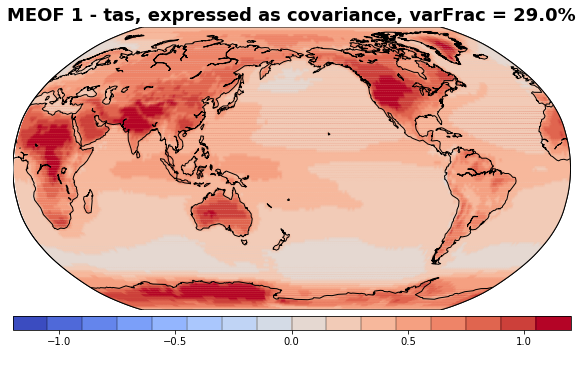

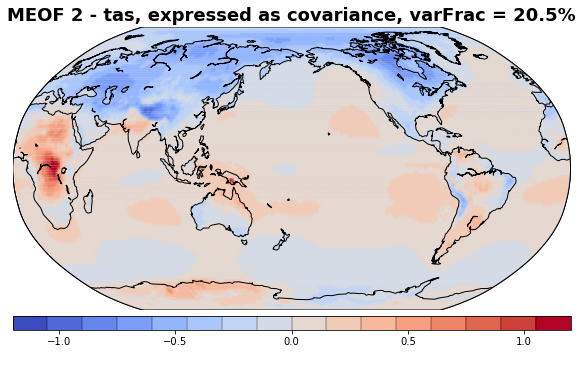

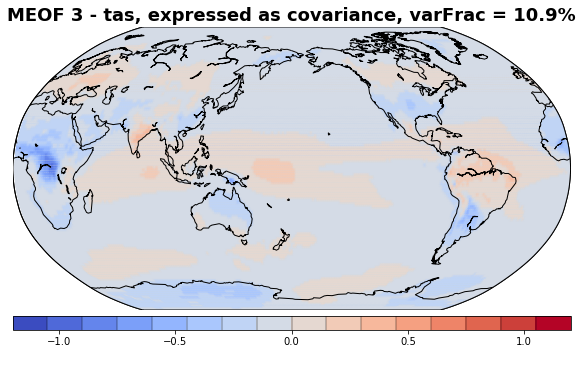

In [39]:
data = eofs_xr['tas']
label_min = -1.2
label_max = 1.2

for eof_nb in [1,2,3] :

    title = "MEOF "+str(eof_nb)+" - tas, expressed as covariance, varFrac = "+str((var_modes[eof_nb-1]*100).round(1))+"%"
    name_figure = "MEOF_EOFmap"+str(eof_nb)+"_tas.png"
    eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

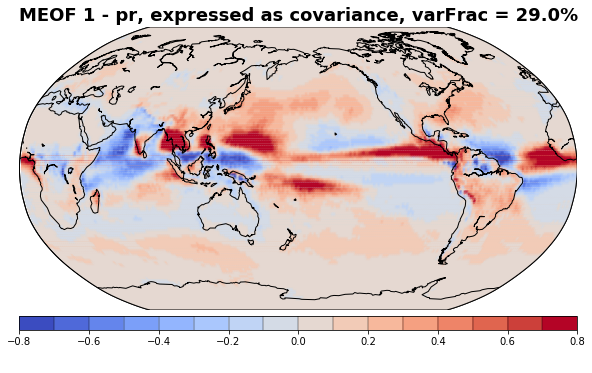

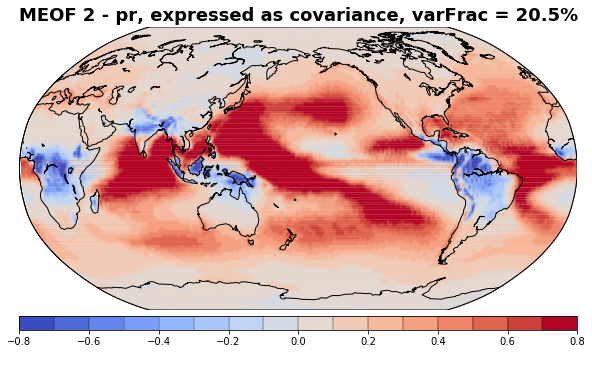

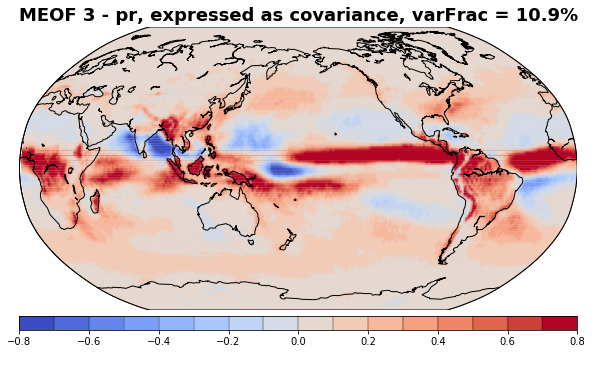

In [43]:
data = eofs_xr['pr']
label_min = -0.8
label_max = 0.8

for eof_nb in [1,2,3] :

    title = "MEOF "+str(eof_nb)+" - pr, expressed as covariance, varFrac = "+str((var_modes[eof_nb-1]*100).round(1))+"%"
    name_figure = "MEOF_EOFmap"+str(eof_nb)+"_pr.png"
    eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

# Emulations Multi-variate pcs

### Skill eval. 

In [35]:
def MultiLinReg(X_train, pc_train, EOF_nb, x_pred) :
    path = "/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/"
    param_names = np.load(file=path+"LHS_paramNames.npy")    

    y_train = pc_train[:,EOF_nb-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(x_pred)
    
    return y_pred

In [80]:
def emulator_eval_EOF_modes(X_train, X_test, y_train, y_test) : 

    # Create an EOF solver to do the EOF analysis. 
    solver = MultivariateEof(y_train, center=False, weights=None)
    pc_train = solver.pcs(npcs=102, pcscaling=1)

    # Prediction and skill evaluation : loop over the 91 modes
    pc_test = solver.projectField(y_test, neofs=102, weighted=False, eofscaling=1)
    x_pred_IS = X_train
    x_pred_OS = X_test
    r_corr_list_IS = []
    r_corr_list_OS = []
    for EOF_nb in range(1,len(pc_train), 1) :
        y_pred_OS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_OS)
        pc_test_tmp = pc_test[:,EOF_nb-1]
        df_OS = pd.DataFrame(y_pred_OS, columns=['pred'])
        df_OS['true'] = pc_test_tmp
        r_corr_OS = np.corrcoef(df_OS['pred'], df_OS['true'])
        r_corr_list_OS.append(r_corr_OS[0,1])
    
        y_pred_IS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_IS)
        df_IS = pd.DataFrame(y_pred_IS, columns=['pred'])
        pc_train_tmp = pc_train[:,EOF_nb-1]
        df_IS['true'] = pc_train_tmp
        r_corr_IS = np.corrcoef(df_IS['pred'], df_IS['true'])
        r_corr_list_IS.append(r_corr_IS[0,1])
    
    return r_corr_list_OS, r_corr_list_IS

In [81]:
from sklearn.model_selection import train_test_split
EOF_nb = 1
X = np.load(file="/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y_tas = anom_w['tas'][1:]
y_pr = anom_w['pr'][1:]

df_fig = pd.DataFrame(range(1, 91, 1), columns=['mode'])
for cpt in range(1,11,1) :
    X_train, X_test, y_tas_train, y_tas_test, y_pr_train, y_pr_test = train_test_split(X, y_tas, y_pr, test_size=0.1)
    y_train = [y_tas_train.to_numpy(), y_pr_train.to_numpy()]
    y_test = [y_tas_test.to_numpy(), y_pr_test.to_numpy()]
    r_corr_list_OS, r_corr_list_IS = emulator_eval_EOF_modes(X_train, X_test, y_train, y_test)
    df_fig['r_OS_'+str(cpt)] = r_corr_list_OS
    df_fig['r_IS_'+str(cpt)] = r_corr_list_IS

df_fig

mode    r_OS_1    r_IS_1    r_OS_2    r_IS_2    r_OS_3    r_IS_3  \
0      1  0.922548  0.945352  0.904454  0.949324  0.787854  0.949803   
1      2  0.873501  0.946280  0.893850  0.949411  0.980101  0.944752   
2      3  0.652601  0.912746  0.643947  0.903842  0.785457  0.897226   
3      4  0.458068  0.841829  0.779110  0.822998  0.115967  0.865532   
4      5  0.463505  0.684380  0.199959  0.758121  0.535907  0.758021   
..   ...       ...       ...       ...       ...       ...       ...   
85    86  0.306430  0.507825  0.227722  0.590323  0.041463  0.503775   
86    87  0.774989  0.400383 -0.222302  0.462715 -0.161665  0.432833   
87    88 -0.225219  0.424772  0.191130  0.544345  0.064059  0.459191   
88    89  0.065305  0.465056 -0.206694  0.491584 -0.263697  0.521193   
89    90  0.560379  0.395526 -0.303328  0.472602  0.093362  0.449715   

      r_OS_4    r_IS_4    r_OS_5  ...    r_OS_6    r_IS_6    r_OS_7    r_IS_7  \
0   0.819510  0.951623  0.775995  ...  0.903265  0.941003  0.967054  0.938552   
1   0.744754  0.954514  0.943963  ...  0.755098  0.955079  0.876681  0.947781   
2   0.720530  0.895289  0.655520  ...  0.945443  0.879607  0.930548  0.879875   
3   0.812581  0.827665  0.118594  ...  0.473367  0.834020  0.680326  0.831461   
4   0.556395  0.768664  0.730176  ...  0.647187  0.757833  0.758177  0.763528   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85 -0.503660  0.434830  0.591402  ...  0.221790  0.534502 -0.060078  0.422450   
86 -0.275431  0.586788  0.087099  ... -0.228640  0.460024  0.142712  0.472680   
87  0.055860  0.482024 -0.347509  ...  0.268962  0.469514  0.188575  0.508644   
88  0.108919  0.503953  0.162788  ... -0.192162  0.461596 -0.039999  0.409741   
89  0.013311  0.374931 -0.036747  ... -0.227341  0.407814  0.088798  0.498598   

      r_OS_8    r_IS_8    r_OS_9    r_IS_9   r_OS_10   r_IS_10  
0   0.947870  0.942455  0.923700  0.945134  0.874163  0.947560  
1   0.756600  0.952820  0.903301  0.954451  0.883992  0.941972  
2   0.688435  0.894061  0.806089  0.885736  0.692419  0.909830  
3   0.799959  0.794241  0.746264  0.830769  0.592408  0.850669  
4   0.576106  0.836468  0.290757  0.704577 -0.190162  0.752414  
..       ...       ...       ...       ...       ...       ...  
85  0.027398  0.466434  0.109724  0.484889 -0.118644  0.465866  
86 -0.077975  0.392297 -0.296861  0.602412  0.579882  0.477813  
87 -0.658459  0.459880  0.306759  0.404086 -0.290098  0.491153  
88 -0.419791  0.403698 -0.359519  0.449214  0.007329  0.475291  
89  0.139091  0.575063  0.145245  0.364781 -0.169937  0.375950  

[90 rows x 21 columns]

In [83]:
df_OS = pd.DataFrame(df_fig['r_OS_1'], columns=['r1'])
df_IS = pd.DataFrame(df_fig['r_IS_1'], columns=['r1'])

for j in range(2,11,1) :
    df_OS['r'+str(j)] = df_fig['r_OS_'+str(j)]
    df_IS['r'+str(j)] = df_fig['r_IS_'+str(j)]

r_OS_mean = df_OS.mean(axis = 1)
r_OS_std = df_OS.std(axis = 1)
df_fig['r_OS_mean'] = r_OS_mean
df_fig['r_OS_std'] = r_OS_std

r_IS_mean = df_IS.mean(axis = 1)
r_IS_std = df_IS.std(axis = 1)
df_fig['r_IS_mean'] = r_IS_mean
df_fig['r_IS_std'] = r_IS_std

df_fig['mode'] = range(0, 90, 1)
df_fig

mode    r_OS_1    r_IS_1    r_OS_2    r_IS_2    r_OS_3    r_IS_3  \
0      0  0.922548  0.945352  0.904454  0.949324  0.787854  0.949803   
1      1  0.873501  0.946280  0.893850  0.949411  0.980101  0.944752   
2      2  0.652601  0.912746  0.643947  0.903842  0.785457  0.897226   
3      3  0.458068  0.841829  0.779110  0.822998  0.115967  0.865532   
4      4  0.463505  0.684380  0.199959  0.758121  0.535907  0.758021   
..   ...       ...       ...       ...       ...       ...       ...   
85    85  0.306430  0.507825  0.227722  0.590323  0.041463  0.503775   
86    86  0.774989  0.400383 -0.222302  0.462715 -0.161665  0.432833   
87    87 -0.225219  0.424772  0.191130  0.544345  0.064059  0.459191   
88    88  0.065305  0.465056 -0.206694  0.491584 -0.263697  0.521193   
89    89  0.560379  0.395526 -0.303328  0.472602  0.093362  0.449715   

      r_OS_4    r_IS_4    r_OS_5  ...    r_OS_8    r_IS_8    r_OS_9    r_IS_9  \
0   0.819510  0.951623  0.775995  ...  0.947870  0.942455  0.923700  0.945134   
1   0.744754  0.954514  0.943963  ...  0.756600  0.952820  0.903301  0.954451   
2   0.720530  0.895289  0.655520  ...  0.688435  0.894061  0.806089  0.885736   
3   0.812581  0.827665  0.118594  ...  0.799959  0.794241  0.746264  0.830769   
4   0.556395  0.768664  0.730176  ...  0.576106  0.836468  0.290757  0.704577   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85 -0.503660  0.434830  0.591402  ...  0.027398  0.466434  0.109724  0.484889   
86 -0.275431  0.586788  0.087099  ... -0.077975  0.392297 -0.296861  0.602412   
87  0.055860  0.482024 -0.347509  ... -0.658459  0.459880  0.306759  0.404086   
88  0.108919  0.503953  0.162788  ... -0.419791  0.403698 -0.359519  0.449214   
89  0.013311  0.374931 -0.036747  ...  0.139091  0.575063  0.145245  0.364781   

     r_OS_10   r_IS_10  r_OS_mean  r_OS_std  r_IS_mean  r_IS_std  
0   0.874163  0.947560   0.878207  0.069107   0.946841  0.005581  
1   0.883992  0.941972   0.859816  0.086838   0.949625  0.004837  
2   0.692419  0.909830   0.763154  0.112799   0.895270  0.011952  
3   0.592408  0.850669   0.568731  0.278036   0.834942  0.021088  
4  -0.190162  0.752414   0.456056  0.305023   0.760808  0.033954  
..       ...       ...        ...       ...        ...       ...  
85 -0.118644  0.465866   0.059680  0.296778   0.478481  0.058454  
86  0.579882  0.477813  -0.050354  0.282687   0.485617  0.067810  
87 -0.290098  0.491153  -0.024525  0.331442   0.475879  0.038569  
88  0.007329  0.475291  -0.133647  0.204305   0.464102  0.039642  
89 -0.169937  0.375950  -0.028616  0.167247   0.441678  0.068995  

[90 rows x 25 columns]

In [84]:
cumul_corr_mean = []
cumul_corr_std = []
for i in range(0, len(df_fig), 1) :
    tmp = df_fig[0:i]['r_OS_mean'].mean()
    cumul_corr_mean.append(tmp)
    
    tmp = df_fig[0:i]['r_OS_std'].mean()
    cumul_corr_std.append(tmp)
    
df_fig['cumul_corr_mean'] = cumul_corr_mean
df_fig['cumul_corr_std'] = cumul_corr_std

In [85]:
## Test moyenne de corrélation pour 5, 10, 15, 20, 25, 50, 75 
mean_OS_5 = df_fig[0:5]['r_OS_mean'].mean()
mean_OS_10 = df_fig[0:10]['r_OS_mean'].mean()
mean_OS_15 = df_fig[0:15]['r_OS_mean'].mean()
mean_OS_20 = df_fig[0:20]['r_OS_mean'].mean()
mean_OS_25 = df_fig[0:25]['r_OS_mean'].mean()
mean_OS_50 = df_fig[0:50]['r_OS_mean'].mean()

In [91]:
trunc=23

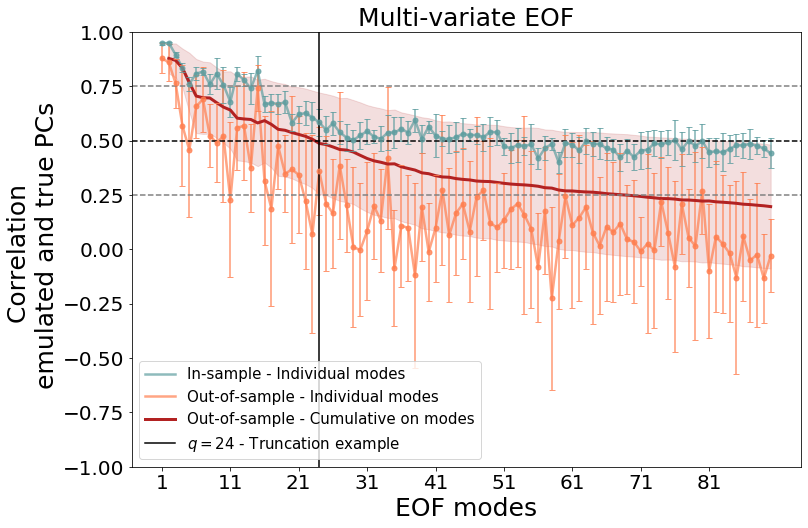

In [92]:
plt.figure(figsize=(12, 8))
    

ax = plt.gca()

df_fig.plot(kind='line', y='r_IS_mean', color = 'cadetblue', alpha=0.7, linewidth=2.5, ax=ax)
df_fig.plot(kind='line', y='r_OS_mean', color = 'coral', alpha=0.7, linewidth=2.5, ax=ax)

df_fig.plot(kind='line', y='cumul_corr_mean', color = 'firebrick', alpha=1, linewidth=3, ax=ax)
xfit = df_fig['mode']
yfit = df_fig['cumul_corr_mean']
dyfit = df_fig['cumul_corr_std']
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='firebrick', alpha=0.15)

plt.errorbar(x=df_fig['mode'], y=df_fig['r_IS_mean'], yerr=df_fig['r_IS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='cadetblue', 
             color= 'cadetblue')

plt.errorbar(x=df_fig['mode'], y=df_fig['r_OS_mean'], yerr=df_fig['r_OS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='coral', 
             color= 'coral')

plt.axhline(y=0.5, color='black', linestyle='dashed', label = '_nolegend_')
plt.axhline(y=0.25, color='gray', linestyle='dashed', label = '_nolegend_')
plt.axhline(y=0.75, color='gray', linestyle='dashed', label = '_nolegend_')

plt.axvline(x=trunc, color='black', linestyle='solid')

#ax.axhline(0, color='k', alpha=0.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('EOF modes', size = 25)
ax.set_ylabel('Correlation \n emulated and true PCs', size = 25)
ax.set_title('Multi-variate EOF', fontsize=25)
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(1, 91, 10))

plt.xticks(rotation=0)

# Legend .................

legend = [ 'In-sample - Individual modes', 'Out-of-sample - Individual modes', 
          'Out-of-sample - Cumulative on modes', '$q=$'+str(trunc+1)+' - Truncation example']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/PPE/figures/Skill_emul_multi.png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [48]:
tmp = (var_modes[0:24].sum()*100).round(2)
tmp 

89.97

### Predictions

In [29]:
def MultiLinReg(X_train, pc_train, EOF_nb, x_pred) :
    path = "/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/"
    param_names = np.load(file=path+"LHS_paramNames.npy")    

    y_train = pc_train[:,EOF_nb-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(x_pred)
    
    return y_pred

In [30]:
path = "/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param_standard.npy")
X = np.load(file=path+"/X_EmulateurFeedbacksN.npy")
param_names = np.load(file=path+"/LHS_paramNames.npy")

pc_pred = []
for EOF_nb in range(1,24,1) :
    #print(i)
    tmp = MultiLinReg(X ,pc_PPE[1:,:], EOF_nb, LHS)
    pc_pred.append(tmp)


In [33]:
shape(pc_pred)

(23, 100000)

In [31]:
df_pc_pred = pd.DataFrame(pc_pred[0], columns= ['EOF 1'])
for i in range(1,23,1) :
    ind = 'EOF '+str(i+1)
    df_pc_pred[ind] = pc_pred[i]
df_pc_pred

EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0      0.043160 -0.385757  1.026827 -0.180840  0.228337 -0.961907  0.092952   
1      0.330120 -0.791206  0.954033 -0.832887  0.461878 -1.136765  0.382692   
2     -0.066589  0.353166 -0.394903  0.783184  1.204326  0.623072  0.288841   
3     -0.796956  0.840286  1.204864 -1.522660  0.682949 -0.810810  0.032945   
4      0.793177 -0.011552  0.342240  0.006793 -1.951357  0.169636 -0.428714   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.165563 -0.189894 -1.125193  0.805565  0.253516 -0.665613  0.887904   
99996 -1.003677  0.435976 -0.308276  0.028773  1.048078 -0.667679  0.116090   
99997  0.931339 -0.470418  0.124719  0.543951  1.638292  0.216213  0.023489   
99998 -1.138446 -1.625253  1.530357 -0.227877  0.669423  0.524856  0.849437   
99999 -0.123120  0.136445  0.141925 -0.821425  0.107720  0.209082 -1.963588   

          EOF 8     EOF 9    EOF 10  ...    EOF 14    EOF 15    EOF 16  \
0      0.059720  0.313144 -0.056528  ...  0.573861  0.473794  0.775831   
1      0.296861  0.766654 -0.539987  ... -0.431302  0.063022 -0.753414   
2     -0.131665  0.644145  0.768847  ... -0.343793 -0.310119  0.943211   
3      2.177466  1.756555 -0.102185  ...  0.939339 -0.800127 -0.070433   
4     -0.895922 -1.420764  0.120681  ... -0.263173  0.378171  0.632182   
...         ...       ...       ...  ...       ...       ...       ...   
99995 -0.459883  0.193968 -0.287573  ...  0.447754 -1.163317  0.784968   
99996 -0.354589 -2.182123 -1.178246  ... -0.088019  0.681468  0.105319   
99997 -1.095887  0.927898 -0.244741  ... -0.007717  0.542246  0.185513   
99998 -1.041726  0.327582  0.044959  ...  0.996529  0.928611 -1.509197   
99999 -0.164194  0.452521  0.503972  ...  0.440482 -0.493758 -1.426549   

         EOF 17    EOF 18    EOF 19    EOF 20    EOF 21    EOF 22    EOF 23  
0      1.026210  0.476874  1.021178  0.533144 -0.657425  0.512666  0.063280  
1      0.889254  1.480338 -0.257668  1.830142  0.383405  0.140133 -0.839683  
2      1.563503  1.228905  0.703679 -0.643551  0.655306  1.605401  1.599898  
3     -0.275459 -1.176093  0.445054  1.269222  0.006859 -0.918274 -1.296681  
4      0.368557  1.629234  0.822299  0.099098 -0.266460  0.965025  0.990670  
...         ...       ...       ...       ...       ...       ...       ...  
99995 -0.658148  0.576930 -0.762942  0.960859 -1.101026  0.052282  0.300551  
99996 -1.224994  1.096612  0.912014  0.023829 -1.032125 -0.431664  0.896087  
99997  2.802923  0.388662 -0.858238  0.246864  0.507404  0.210953 -1.005007  
99998  0.238014  0.187794 -1.423886 -1.019103  0.262505 -0.077709  0.731496  
99999 -1.643008 -0.080997 -0.005616  0.553370 -1.053421 -0.201461 -0.957888  

[100000 rows x 23 columns]

# Calcule RMSE reconstructed (p)

### Avec reconstruction 

In [35]:
eofs_combined = {}
for var in variables :
    
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr[var]

In [36]:
#eofs_combined = {}
#for var in variables :
    #for j in range(1, 23, 1) :
        ## --Get the eofs
    #    eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+var+".npy").to_xarray().to_array()
    #    eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
    #    eofs[var].append(eof_tmp)

    ## --Combine the modes for reconstruction
#    eofs_combined[var] = xr.combine_nested(eofs[var], concat_dim='eofs')

In [55]:
## --Project and reconstruct the observations
X_obs_rec = {}

U_obs = solver.projectField([X_obs_w['tas'].to_numpy(), X_obs_w['pr'].to_numpy()], neofs=24, 
                                 weighted=False, eofscaling=1)
for var in variables : 
    X_obs_rec[var] = reconstruct_X(eofs_combined[var][0:24], 
                               pc=U_obs, nb_dims=2)

In [37]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

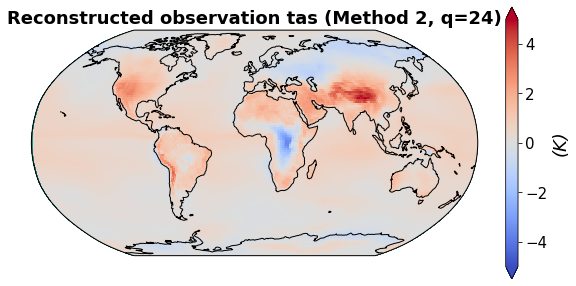

In [59]:
dataset = X_obs_rec['tas']
var = dataset[:]
palette = "coolwarm"
xmin = -5
xmax = 5
label = '(K)'
title = 'Reconstructed observation tas (Method 2, q=24)'
name_fig = 'Rec_obs_tas_meth2.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

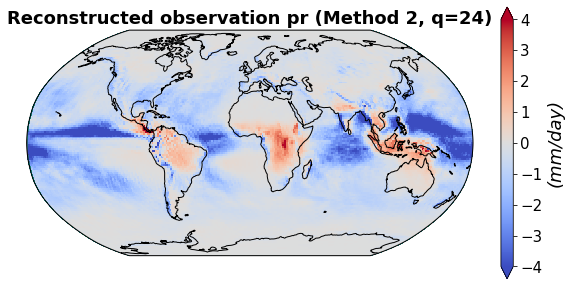

In [58]:
dataset = X_obs_rec['pr']
var = dataset[:]
palette = "coolwarm"
xmin = -4
xmax = 4
label = '(mm/day)'
title = 'Reconstructed observation pr (Method 2, q=24)'
name_fig = 'Rec_obs_pr_meth2.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [61]:
## --Project and reconstruct p1
X_p1_rec = {}
p_p1 = {}

X = [X_p1_w['tas']['tas'].to_numpy(), X_p1_w['pr']['pr'].to_numpy()]

U_p1 = solver.projectField(X, weighted=False, eofscaling=1)

for var in variables :
    X_p1_rec[var] = reconstruct_X(eofs_combined[var][0:24], pc=U_p1[0:24], nb_dims=2)

    ## --Param. error p(\theta_0)
    p_p1[var] = MSE_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)

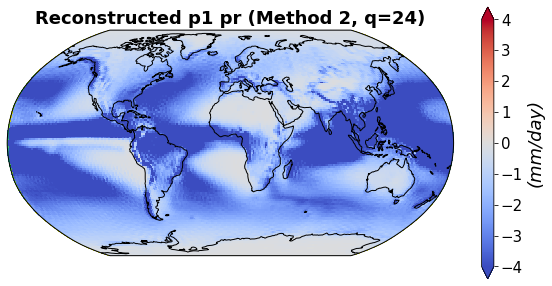

In [62]:
dataset = X_p1_rec['pr']
var = dataset[:]
palette = "coolwarm"
xmin = -4
xmax = 4
label = '(mm/day)'
title = 'Reconstructed p1 pr (Method 2, q=24)'
name_fig = 'Rec_p1_pr_meth2.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

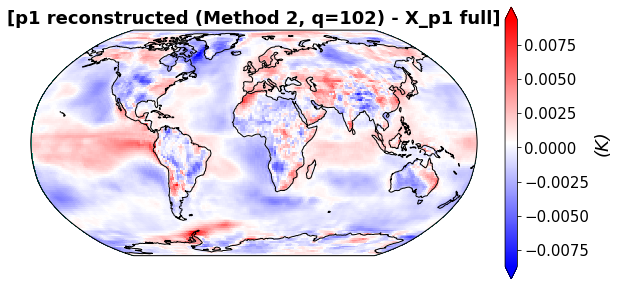

In [54]:
dataset = (X_p1_rec['tas'] - X_p1_w['tas']['tas'])
var = dataset[:]
palette = "bwr"
xmin = var.min()
xmax = var.max()
label = '(K)'
title = '[p1 reconstructed (Method 2, q=102) - X_p1 full]'
name_fig = 'Diff_rec_p1_meth2_full_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

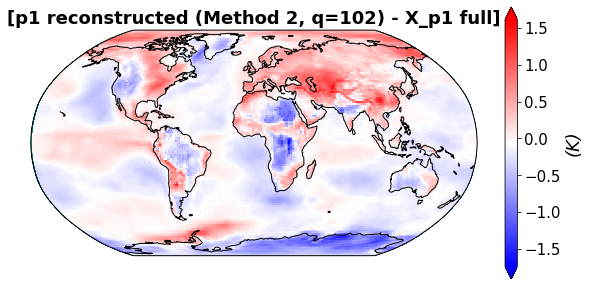

In [48]:
dataset = X_p1_rec['tas']# - X_p1_w['tas'])['tas']
var = dataset[:]
palette = "bwr"
xmin = var.min()
xmax = var.max()
label = '(K)'
title = '[p1 reconstructed (Method 2, q=102) - X_p1 full]'
name_fig = 'Diff_rec_p1_meth2_full_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [39]:
## --Project and reconstruct the observations
X_obs_rec = {}

U_obs = solver.projectField([X_obs_w['tas'].to_numpy(), X_obs_w['pr'].to_numpy()], neofs=24, 
                                 weighted=False, eofscaling=1)
for var in variables : 
    X_obs_rec[var] = reconstruct_X(eofs_combined[var][0:24], 
                               pc=U_obs, nb_dims=2)

## --Project and reconstruct p1
X_p1_rec = {}
p_p1 = {}

X = [X_p1_w['tas']['tas'].to_numpy(), X_p1_w['pr']['pr'].to_numpy()]

U_p1 = solver.projectField(X, neofs=24, weighted=False, eofscaling=1)

for var in variables :
    X_p1_rec[var] = reconstruct_X(eofs_combined[var][0:24], pc=U_p1, nb_dims=2)

    ## --Param. error p(\theta_0)
    p_p1[var] = MSE_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)

In [40]:
float(p_p1['tas'])

0.8457279924640688

In [46]:
U = (U_p1 - U_obs)**2
X_tas = reconstruct_X(eofs_combined[var][0:24], pc=U, nb_dims=2)

In [49]:
var = 'tas'
diff = (X_p1_rec[var] - X_obs_rec[var])**2

In [50]:
X_tas - diff

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.45509401, -0.45509401, -0.45509401, ..., -0.45509401,
        -0.45509401, -0.45509401],
       [-0.00901733, -0.00901733, -0.00901733, ..., -0.00901733,
        -0.00901733, -0.00901733],
       [-0.14827967, -0.14827967, -0.14827967, ..., -0.0943241 ,
        -0.14827967, -0.14827967],
       ...,
       [ 0.35417085,  0.35417085,  0.35417085, ...,  0.39884392,
         0.35417085,  0.35417085],
       [ 0.21460458,  0.21460458,  0.21460458, ...,  0.21460458,
         0.21460458,  0.21460458],
       [-0.089546  , -0.089546  , -0.089546  , ..., -0.089546  ,
        -0.089546  , -0.089546  ]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [38]:
nb_dims = 2
p_pred = {}
for var in variables :
    print(var)
    p_pred[var] = []
    for i in range(0,100000,1) : 
        pc = df_pc_pred[var].iloc[i]
        X_mod_rec = reconstruct_X(eofs_combined[var], pc[0:18], nb_dims)
        tmp = MSE_rec(X_mod_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_pred[var].append(float(tmp))
    df_pc_pred[var]['p'] = p_pred[var]
    #df_pc_pred

tas
pr


In [39]:
## --Save 
np.save(path_files+'npy/df_pc_pred_tas.npy', df_pc_pred['tas'].values)
np.save(path_files+'npy/df_pc_pred_pr.npy', df_pc_pred['pr'].values)

## Erreure multi-variée 

In [36]:
## -- Create list for column names 
col = []
for i in range(1,19,1) :
    col.append('EOF '+str(i))
col.append('p')
    
## -- load data 
df_pc_pred = {}
for var in variables :
    tmp = np.load(path_files+'npy/df_pc_pred_'+var+'.npy')
    df_pc_pred[var] = pd.DataFrame(tmp, columns=col)


In [37]:
for var in variables :
    df_pc_pred[var]['p_norm'] = df_pc_pred[var]['p']/float(p_p1[var])

df_multi = pd.DataFrame()
df_multi['p_tas_norm'] = df_pc_pred['tas']['p_norm']
df_multi['p_pr_norm'] = df_pc_pred['pr']['p_norm']
df_multi['p_multi'] = (df_multi['p_tas_norm']+df_multi['p_pr_norm'])/2
df_multi

p_tas_norm  p_pr_norm   p_multi
0        1.100036   0.147677  0.623856
1        1.202193   0.161834  0.682014
2        1.295959   0.249785  0.772872
3        2.716612   0.271492  1.494052
4        0.656915   0.215119  0.436017
...           ...        ...       ...
99995    0.726091   0.273961  0.500026
99996    1.794400   0.287646  1.041023
99997    1.285557   0.173247  0.729402
99998    2.565031   0.070061  1.317546
99999    1.239751   0.172724  0.706238

[100000 rows x 3 columns]

In [38]:
## -- Identify best candidate 
best_index = df_multi['p_multi'].idxmin()
best_p_multi = df_multi['p_multi'].iloc[best_index]
best_p_tas_norm = df_multi['p_tas_norm'].iloc[best_index]
best_p_pr_norm = df_multi['p_pr_norm'].iloc[best_index]

In [39]:
best_p_pr_norm

0.27879580477675664

# ---------- Just to select candidates -------------

## Selection lower than ref

In [42]:
cpt_drop=[]
cpt=0
for i in df_multi['p_multi'] : 
    if i>1.0 : 
        cpt_drop.append(cpt)
        cpt+=1
    else :
        cpt+=1

In [43]:
df_pc_best = {}
for var in variables :
    tmp = df_pc_pred[var].copy()
    df_pc_best[var] = tmp.drop(cpt_drop)
    df_pc_best[var] = df_pc_best[var].reset_index()
df_pc_best[var]

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0          0  0.670288 -0.790521  0.029989  0.785455 -0.062077 -0.609458   
1          1  1.095571 -0.999211 -0.020168  0.917900  1.258599  0.056930   
2          2 -0.528764  0.536298  0.526450 -0.336078 -0.467179 -0.248779   
3          4  0.033719 -0.757257 -0.879496 -0.669543 -0.347216  0.714384   
4          5  0.061282 -1.834802 -0.907971 -1.587969 -0.097403  1.194729   
...      ...       ...       ...       ...       ...       ...       ...   
74804  99991 -0.154453 -0.644050  0.239962  0.329219  0.650169 -0.772494   
74805  99994 -0.862107  0.145841 -0.228162 -0.548818  0.655254  0.783710   
74806  99995 -0.390304  1.001070 -0.608099  0.483360  1.211396 -0.429256   
74807  99997  0.366495 -0.201414  0.134204  0.175639  0.034514  0.019771   
74808  99999  0.173894 -0.217926  0.112853  0.633414 -0.165441  1.873292   

          EOF 7     EOF 8     EOF 9  ...    EOF 11    EOF 12    EOF 13  \
0      0.876451  0.264218  0.304293  ... -0.441925  0.086703 -0.451636   
1      0.301744  0.382213 -0.473981  ...  0.056880  0.426517  1.160920   
2      0.756709 -0.596996  0.885692  ... -0.150732  0.146812  0.263039   
3     -0.486613  0.006203 -0.952759  ...  0.651977 -0.603233  0.330525   
4     -0.711546 -0.793513 -0.235365  ...  0.024402 -0.971234  0.060953   
...         ...       ...       ...  ...       ...       ...       ...   
74804 -0.833779 -0.565921  0.258335  ...  0.123236  0.144185 -0.973254   
74805 -0.539680  0.971426  0.503236  ...  0.458142  0.228707  0.396075   
74806  0.116171  0.477464 -0.038712  ...  0.533115  1.318071 -0.001952   
74807  1.030345 -2.307188 -0.869328  ... -1.312696 -0.685861 -1.054423   
74808 -0.043440 -0.107136  0.207804  ...  0.076502  0.533721 -0.099815   

         EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p    p_norm  
0     -0.143881 -0.444148  0.631852  1.073848  0.874232  1.172499  0.147677  
1     -0.724864  0.372936  1.139522  1.717078  0.408300  1.284901  0.161834  
2     -0.820059  0.395175  1.099081 -0.034834  1.166305  1.983196  0.249785  
3     -1.224742  0.805191  0.000496  1.089089  0.698498  1.707968  0.215119  
4     -0.418991 -0.262695 -0.821049 -0.254316 -0.621489  2.343570  0.295174  
...         ...       ...       ...       ...       ...       ...       ...  
74804 -0.127228  0.330000  0.939830 -0.985002  0.919820  1.805765  0.227437  
74805  0.178940 -0.091134 -0.963954  0.296419  0.339819  2.616702  0.329575  
74806  1.346793  1.088495  0.407556  0.252647 -0.074069  2.175151  0.273961  
74807  0.609246  0.402423  2.497775 -0.671741  0.110514  1.375516  0.173247  
74808  0.289441 -0.096714 -0.069145 -1.050398 -0.732936  1.371365  0.172724  

[74809 rows x 21 columns]

In [42]:
## -- save
np.save(path_files+'npy/df_pc_low_tas.npy', df_pc_best['tas'].values)
np.save(path_files+'npy/df_pc_low_pr.npy', df_pc_best['pr'].values)

## Compute distances and drop near-neighbors

In [40]:
def Drop_candidates(df_pc_best, nb_drop, d_mean) :
    d_list = {}
    df_pc_best_shuffle = {}
    for var in variables :
        print(var)
        ## -- Shuffle the data :
        #df_pc_best_shuffle[var] = df_pc_best[var].sample(frac=1).reset_index().drop('level_0', axis=1)
    
        ## -- Compute inter-point distances :
        nb_dims = 2
        d_list[var] = []
        ind1_list = []
        ind2_list = []
        for i in range(0,int(len(df_pc_best[var])-1),2) : 
            #print(i)
            pc1 = df_pc_best[var].iloc[i][1:-1]
            pc2 = df_pc_best[var].iloc[i+1][1:-1]
    
            X_pc1 = reconstruct_X(eofs_combined[var], pc1[0:18], nb_dims)
            X_pc2 = reconstruct_X(eofs_combined[var], pc2[0:18], nb_dims)
    
            tmp = MSE_rec(X_pc1, X_pc2, Mean[var], W_rmse_2D)
            d_list[var].append(float(tmp))
            ind1_list.append(i)
            ind2_list.append(i+1)
        
    ## -- Sort distances and select index to drop :
    df_d = pd.DataFrame(d_list['tas'], columns=['d_tas'])
    df_d['d_pr'] = d_list['pr']
    df_d['d_multi'] = df_d['d_tas']/d_mean['tas'] + df_d['d_pr']/d_mean['pr']
    df_d['ind1'] = ind1_list
    df_d['ind2'] = ind2_list
    df_d_sorted = df_d.sort_values(by='d_multi').reset_index()
    print(df_d_sorted)
    ind_drop = []
    for i in range(0, nb_drop, 1) :
        #print(i)
        ind_drop_tmp = random.choice([df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i]])
        #print(df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i])
        #print(ind_drop_tmp)
        ind_drop.append(ind_drop_tmp)
    #print(ind_drop)
    ## -- Drop candidate : 
    df_res = {}
    for var in variables :
        df_res[var] = df_pc_best[var].drop(ind_drop)
    
    ## -- Return DataFrame - 1 candidates : 
    return df_res

In [44]:
d_list = {}
d_mean = {}
for var in variables :
        print(var)
        
        ## -- Compute inter-point distances :
        nb_dims = 2
        d_list[var] = []
        for i in range(0,int(len(df_pc_best[var])-1),2) : 
            #print(i)
            pc1 = df_pc_best[var].iloc[i][1:-1]
            pc2 = df_pc_best[var].iloc[i+1][1:-1]
    
            X_pc1 = reconstruct_X(eofs_combined[var], pc1[0:18], nb_dims)
            X_pc2 = reconstruct_X(eofs_combined[var], pc2[0:18], nb_dims)
    
            tmp = MSE_rec(X_pc1, X_pc2, Mean[var], W_rmse_2D)
            d_list[var].append(float(tmp))
            
        d_mean[var] = float(xr.DataArray(d_list[var]).mean())

tas
pr


In [50]:
## -- Create list for column names 
col = []
for i in range(0,58,1) :
    j = (59-i)
    col.append('index_'+str(j))
col.append('index')

for i in range(1,19,1) :
    col.append('EOF '+str(i))
col.append('p')
col.append('p_norm')

## -- load data
df_pc_best = {}
for var in variables :
    tmp = np.load(path_files+'npy/df_pc_best_'+var+'.npy')
    df_pc_best[var] = pd.DataFrame(tmp, columns=col)

In [56]:
len(df[var])/2

7554.5

In [ ]:
nb_drop = 5000
#df = df_pc_best.copy()
cpt=0
while len(df['tas']['p']) > 5 :
    print(cpt)
    df = Drop_candidates(df, nb_drop, d_mean)
    df['tas'].rename(columns = {'level_0':'index_'+str(cpt)}, inplace = True)
    df['pr'].rename(columns = {'level_0':'index_'+str(cpt)}, inplace = True)
    df['tas'] = df['tas'].reset_index()
    df['pr'] = df['pr'].reset_index()
    print(df)
    cpt+=1

0
tas
pr
      index      d_tas       d_pr    d_multi   ind1   ind2
0      6395   0.690552   0.667123   1.549639  12790  12791
1      6572   0.690552   0.667123   1.549639  13144  13145
2      5789   0.690552   0.667123   1.549639  11578  11579
3      6510   0.690552   0.667123   1.549639  13020  13021
4      6498   0.690552   0.667123   1.549639  12996  12997
...     ...        ...        ...        ...    ...    ...
7549   7244  12.441717  13.380018  29.369302  14488  14489
7550   3544  12.919292  14.997867  31.673093   7088   7089
7551   2209  13.382927  14.647269  31.862809   4418   4419
7552   6555  14.444775  17.168536  35.838873  13110  13111
7553   7473  17.472541  17.179654  39.528929  14946  14947

[7554 rows x 6 columns]
{'tas':        level_0  index_0  index_59  index_58  index_57  index_56  index_55  \
0            0        1       1.0       1.0       1.0       1.0       1.0   
1            3        7       7.0       7.0       7.0       7.0       7.0   
2            4     

In [53]:
df['tas']

level_0  index_59  index_58  index_57  index_56  index_55  index_54  \
0            1       1.0       1.0       1.0       1.0       1.0       1.0   
1            2       2.0       2.0       2.0       2.0       2.0       2.0   
2            5       5.0       5.0       5.0       5.0       5.0       5.0   
3            7       7.0       7.0       7.0       7.0       7.0       7.0   
4            9       9.0       9.0       9.0       9.0       9.0       9.0   
...        ...       ...       ...       ...       ...       ...       ...   
15104    25102   26102.0   27101.0   28100.0   29100.0   30100.0   31100.0   
15105    25104   26104.0   27103.0   28103.0   29103.0   30103.0   31103.0   
15106    25105   26105.0   27105.0   28105.0   29105.0   30105.0   31105.0   
15107    25107   26107.0   27107.0   28107.0   29107.0   30107.0   31107.0   
15108    25108   26108.0   27108.0   28108.0   29108.0   30108.0   31108.0   

       index_53  index_52  index_51  ...    EOF 11    EOF 12    EOF 13  \
0           1.0       1.0       1.0  ...  0.106225  1.624095  0.920702   
1           2.0       2.0       2.0  ... -0.965773 -0.335608 -0.420781   
2           5.0       5.0       5.0  ...  0.627476 -1.795416 -1.621383   
3           7.0       7.0       7.0  ...  0.623071 -0.387462 -0.148986   
4           9.0       9.0       9.0  ...  0.395075  1.092358  0.223374   
...         ...       ...       ...  ...       ...       ...       ...   
15104   32100.0   33100.0   34100.0  ... -0.084823  0.032636 -0.207753   
15105   32103.0   33103.0   34103.0  ... -1.470023  0.005112  1.027627   
15106   32105.0   33105.0   34105.0  ...  0.794998  0.526334 -0.219903   
15107   32107.0   33107.0   34107.0  ...  0.543456  0.662341  0.186721   
15108   32108.0   33108.0   34108.0  ... -0.853963 -1.462664 -1.414264   

         EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p    p_norm  
0      1.138463  1.913375 -1.009275  0.666004 -0.200700  1.364168  1.295959  
1     -0.830582 -0.770455 -0.512789  0.183500 -0.401789  1.011029  0.960477  
2     -1.177933 -0.507719 -0.073077  0.019042 -0.074647  1.325540  1.259263  
3      0.837503 -0.396881 -0.241797 -0.805868 -0.268905  0.891043  0.846491  
4      0.706767 -0.199553 -0.530752  0.725435 -1.005626  1.236046  1.174243  
...         ...       ...       ...       ...       ...       ...       ...  
15104  0.055438 -0.155580  1.734973 -0.872369 -0.139545  1.391381  1.321812  
15105 -0.430765  0.100909 -0.903232 -0.611623 -0.196328  1.016614  0.965783  
15106  0.246554  0.136929  0.177914  0.718915 -0.022122  0.796712  0.756876  
15107 -1.133502  0.661931  0.041753  0.986693 -0.312779  1.353218  1.285557  
15108  0.910493 -0.592440  1.195323 -1.538610 -0.827962  1.305002  1.239751  

[15109 rows x 80 columns]

In [48]:
## -- save
np.save(path_files+'npy/df_pc_best_tas.npy', df['tas'].values)
np.save(path_files+'npy/df_pc_best_pr.npy', df['pr'].values)

## From 244 to 5 candidates 

In [38]:
def Drop_candidates_5(df_pc_best, k, nb_drop) :
    ## -- Shuffle the data :
    df_pc_best_shuffle = df_pc_best.sample(frac=1).reset_index().drop('level_0', axis=1)
    
    ## -- Compute inter-point distances :
    nb_dims = 2
    d_list = []
    ind1_list = []
    ind2_list = []
    for i in range(0,int(len(df_pc_best)-1),2) : 
        #print(i)
        pc1 = df_pc_best_shuffle.iloc[i][1:-1]
        pc2 = df_pc_best_shuffle.iloc[i+1][1:-1]
    
        X_pc1 = reconstruct_X(eofs_combined, pc1, nb_dims)
        X_pc2 = reconstruct_X(eofs_combined, pc2, nb_dims)
    
        tmp = RMSE_rec(X_pc1, X_pc2, Mean, W_rmse_2D)
        d_list.append(float(tmp))
        ind1_list.append(i)
        ind2_list.append(i+1)
        
    ## -- Sort distances and select index to drop :
    df_d = pd.DataFrame(d_list, columns=['d'])
    df_d['ind1'] = ind1_list
    df_d['ind2'] = ind2_list
    df_d_sorted = df_d.sort_values(by='d')
    print(df_d_sorted)
    ind_drop = []
    for i in range(0, nb_drop, 1) :
        ind_drop_tmp = random.choice([df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i]])
        print(df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i])
        print(ind_drop_tmp)
        ind_drop.append(ind_drop_tmp)
    print(ind_drop)
    ## -- Drop candidate : 
    df_pc_best_tmp = df_pc_best_shuffle.drop(ind_drop)
    
    ## -- Return DataFrame - 1 candidates : 
    return df_pc_best_tmp

In [39]:
df_pc_low = np.load(path_files+'npy/df_pc_low.npy')
df_pc_low

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0          0  0.053160  0.591416  0.177104  0.866376  0.718467  0.659540   
1          4 -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115   
2          5 -1.469691 -0.875863  1.867064  0.317734  0.117693 -0.040501   
3          7 -0.680900 -1.489689 -0.527394  1.221240  0.160196 -0.208807   
4          8  0.272092 -0.762280  1.690819 -1.126358  0.707616 -1.384625   
...      ...       ...       ...       ...       ...       ...       ...   
27039  99988 -0.098217  0.735165  0.579784 -0.356114 -0.113721 -0.339570   
27040  99989 -0.149039 -0.725431  0.610171 -0.045447 -0.002070 -0.256868   
27041  99990  0.260802 -0.619722  1.692303  0.659605  0.656065  0.420272   
27042  99994  0.143116 -0.908388  0.486532  0.129072 -0.657171 -0.388476   
27043  99999  0.215085 -0.876168  0.095835 -1.244400  1.377519  0.435242   

          EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
0     -0.043037  0.556143  0.368303 -1.033655  0.433413  1.109543  0.321661   
1     -0.430936 -0.878425  0.267369 -0.884294  0.385899  1.002614  0.633993   
2      0.693874 -0.572920  0.494804 -0.681906 -0.965773 -0.335608 -0.420781   
3     -1.040138  0.537645 -1.246970  0.123964 -0.249919 -0.070425  0.553692   
4     -1.228677 -1.250914  0.390563  1.171335  0.627476 -1.795416 -1.621383   
...         ...       ...       ...       ...       ...       ...       ...   
27039  0.282826  0.587459  0.728209 -0.162594 -0.135067 -0.845899  0.242420   
27040  0.127133  1.105932  0.464851 -0.849792  0.272097  0.785348  0.092108   
27041  1.021974 -0.146405  0.256291 -0.410115  1.157031  0.030986 -1.149404   
27042 -0.295390 -0.084206 -0.310382  1.312090 -0.336693 -0.187981 -0.483243   
27043  0.023417  0.754573  0.550383 -0.200962 -0.853963 -1.462664 -1.414264   

         EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
0      1.513375  0.452024 -0.274895 -0.594091  0.293428  1.017980  
1      1.667335  0.034571 -0.438587 -0.113232 -0.295158  0.898584  
2     -0.830582 -0.770455 -0.512789  0.183500 -0.401789  0.985553  
3      0.984406 -0.090978 -0.765705  1.268793  0.568358  0.956223  
4     -1.177933 -0.507719 -0.073077  0.019042 -0.074647  0.960588  
...         ...       ...       ...       ...       ...       ...  
27039  0.680693 -0.674629 -0.947839 -1.431510 -0.483259  0.961969  
27040  1.290776  1.655335  1.314124 -0.300648  0.383312  0.867153  
27041 -0.878397  1.373247  0.333861  0.346994 -0.324414  0.974024  
27042  0.600136 -1.563444  0.047186 -0.411098  0.254532  1.006810  
27043  0.910493 -0.592440  1.195323 -1.538610 -0.827962  0.979270  

[27044 rows x 20 columns]

In [46]:
df_pc_best = np.load(path_files+'npy/df_pc_best.npy')
names = ['index']
for i in range(1, 19,1) :
    tmp = 'EOF '+str(i)
    names.append(tmp)
names.append('p')
df_pc_best = pd.DataFrame(df_pc_best, columns = names)
df_pc_best

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0    85815.0  0.152225 -1.085746 -0.746630 -1.429165  1.778324 -0.704927   
1    22828.0  0.277992 -0.529722  1.790241 -0.182500 -0.110369  0.057310   
2     1225.0 -0.647950 -2.488508  0.408566  0.742035 -0.353631 -1.495663   
3    27632.0 -0.109551 -1.443031 -0.501860 -0.011551 -0.552903 -1.905093   
4    26389.0  0.143250 -1.009471  0.016291  1.270251  0.834224  0.243576   
..       ...       ...       ...       ...       ...       ...       ...   
239  81935.0 -0.904308  0.709754 -0.304156 -1.376968  1.381524 -1.362482   
240  75932.0 -0.487094  0.068024 -0.781826 -0.485898 -0.182639  0.060458   
241  30946.0 -0.770198 -1.098080  1.693766 -2.745980  0.203138 -1.423696   
242  24113.0 -0.266462  0.084505  1.611403 -0.029390 -1.336116 -0.928165   
243  36948.0  0.144695  1.133750  1.100064 -1.311961  1.331608 -0.984794   

        EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
0   -0.439729  0.340014 -0.731285  0.338014 -0.485502  0.454815 -0.679829   
1    1.283522  0.017039  0.226638  0.502907 -0.416427 -0.180738 -2.373941   
2   -0.551574  1.213708 -0.452524  0.595403  0.412884  0.193994  0.201871   
3   -0.510165  0.740858  0.083844  0.384049 -0.949508 -0.411286 -0.775791   
4   -0.058809  1.691300  0.027558  1.213643  0.833129  0.815862  1.392720   
..        ...       ...       ...       ...       ...       ...       ...   
239  1.475598  0.463814  0.524649 -0.097496 -1.598356 -0.891319 -1.281002   
240  0.899225  2.365860 -1.193639  0.984475  0.770270  0.876599 -0.317881   
241  0.565026 -0.263448  1.238164 -0.412457 -0.293237  0.811917 -1.583442   
242 -0.809306 -0.282305  1.127798 -1.075902  0.469477  0.393798 -0.260879   
243 -0.264897  0.317673 -0.381135  0.430401 -1.545997 -0.867277 -1.288236   

       EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
0    0.433715  1.058940  1.618967 -1.019866 -0.178491  0.981345  
1   -1.125957 -0.206899  1.641273  0.110354  0.289527  1.008021  
2   -0.006765  0.201731 -0.184508 -0.528898  0.196640  1.003428  
3   -1.066150  0.806205  1.444820 -0.700865  0.734572  1.012098  
4    1.372376 -0.374092  1.406921  0.261484 -0.030887  0.951570  
..        ...       ...       ...       ...       ...       ...  
239 -1.282367  0.416500  0.382751 -1.286510 -0.198597  0.885943  
240 -0.675205  1.489671  1.703233 -0.487771 -0.006883  0.920187  
241 -0.663818 -0.020659 -0.040446 -0.094407  0.382790  0.855260  
242 -0.211607 -0.067986  0.556047  0.048432  0.397673  0.987180  
243  0.223018  0.546155  0.269942 -1.075030  0.852434  0.977729  

[244 rows x 20 columns]

In [47]:
k=5
nb_drop = 50
for i in range(0,5,1) :
    df_pc_best = Drop_candidates_5(df_pc_best, k, nb_drop)
    cpt+=1
    print(cpt)
df_pc_best

            d  ind1  ind2
113  0.362967   226   227
28   0.371311    56    57
81   0.423568   162   163
106  0.435888   212   213
112  0.444913   224   225
..        ...   ...   ...
2    1.306236     4     5
68   1.320449   136   137
95   1.330770   190   191
48   1.351495    96    97
24   1.404422    48    49

[122 rows x 3 columns]
226 227
226
56 57
56
162 163
162
212 213
213
224 225
224
78 79
78
54 55
54
76 77
76
58 59
58
160 161
161
200 201
200
172 173
172
10 11
11
210 211
210
86 87
87
44 45
44
14 15
14
208 209
208
166 167
167
214 215
215
42 43
43
218 219
219
36 37
36
118 119
119
220 221
220
84 85
84
130 131
130
18 19
18
72 73
73
168 169
169
156 157
157
148 149
148
38 39
38
228 229
229
32 33
33
88 89
89
24 25
25
26 27
27
146 147
147
198 199
198
158 159
159
206 207
206
242 243
243
240 241
241
116 117
116
174 175
174
202 203
202
2 3
2
74 75
74
20 21
21
[226, 56, 162, 213, 224, 78, 54, 76, 58, 161, 200, 172, 11, 210, 87, 44, 14, 208, 167, 215, 43, 219, 36, 119, 220, 84, 130, 18, 73, 1

IndexError: single positional indexer is out-of-bounds

In [49]:
nb_drop = 1
k=5
cpt=0
while len(df_pc_best) > k :
    df_pc_best = Drop_candidates_5(df_pc_best, k, nb_drop)
    cpt+=1
    print(cpt)
df_pc_best

           d  ind1  ind2
21  0.384008    42    43
16  0.480230    32    33
36  0.481132    72    73
26  0.523853    52    53
19  0.544306    38    39
29  0.620331    58    59
43  0.647534    86    87
20  0.659590    40    41
10  0.672346    20    21
9   0.689292    18    19
35  0.723442    70    71
23  0.759471    46    47
17  0.792104    34    35
41  0.812790    82    83
31  0.832937    62    63
18  0.847973    36    37
39  0.864778    78    79
34  0.879304    68    69
14  0.882670    28    29
27  0.883576    54    55
13  0.889809    26    27
28  0.890029    56    57
24  0.894889    48    49
0   0.931534     0     1
6   0.971513    12    13
7   1.034197    14    15
2   1.036880     4     5
5   1.038356    10    11
4   1.038979     8     9
25  1.040221    50    51
37  1.061983    74    75
46  1.073007    92    93
3   1.105876     6     7
8   1.158068    16    17
40  1.161339    80    81
1   1.169817     2     3
12  1.173994    24    25
30  1.195344    60    61
33  1.217224    66    67


           d  ind1  ind2
28  0.423478    56    57
40  0.423561    80    81
25  0.490986    50    51
24  0.521061    48    49
3   0.541528     6     7
35  0.550729    70    71
10  0.555311    20    21
12  0.560752    24    25
26  0.570092    52    53
38  0.570332    76    77
4   0.671671     8     9
15  0.712903    30    31
34  0.738652    68    69
29  0.744797    58    59
8   0.746430    16    17
9   0.753311    18    19
37  0.759320    74    75
14  0.769267    28    29
31  0.778955    62    63
16  0.795358    32    33
32  0.856692    64    65
6   0.900087    12    13
2   0.921911     4     5
13  0.951599    26    27
5   1.004423    10    11
18  1.012686    36    37
1   1.014040     2     3
11  1.016637    22    23
36  1.018289    72    73
27  1.019462    54    55
21  1.138065    42    43
0   1.153670     0     1
17  1.166120    34    35
42  1.167885    84    85
30  1.182610    60    61
23  1.218212    46    47
19  1.230568    38    39
39  1.246914    78    79
33  1.252581    66    67


           d  ind1  ind2
24  0.447847    48    49
15  0.484801    30    31
3   0.493394     6     7
38  0.496457    76    77
26  0.514798    52    53
20  0.547874    40    41
7   0.551578    14    15
0   0.557487     0     1
18  0.609190    36    37
9   0.648405    18    19
29  0.650549    58    59
36  0.658104    72    73
14  0.668220    28    29
19  0.680857    38    39
25  0.703613    50    51
31  0.750715    62    63
32  0.813508    64    65
11  0.816079    22    23
35  0.832073    70    71
33  0.879523    66    67
10  0.895816    20    21
28  0.918147    56    57
8   0.925850    16    17
6   0.928888    12    13
13  0.945822    26    27
16  0.970775    32    33
2   0.973712     4     5
12  0.985332    24    25
27  0.993560    54    55
5   0.997733    10    11
34  1.001086    68    69
17  1.039886    34    35
21  1.069441    42    43
4   1.069981     8     9
1   1.180924     2     3
30  1.252719    60    61
37  1.281965    74    75
22  1.290894    44    45
23  1.504933    46    47


           d  ind1  ind2
1   0.427641     2     3
34  0.449795    68    69
4   0.510774     8     9
31  0.544575    62    63
23  0.561536    46    47
7   0.565832    14    15
18  0.615102    36    37
5   0.673001    10    11
30  0.682135    60    61
17  0.708785    34    35
0   0.723597     0     1
6   0.748992    12    13
11  0.786330    22    23
14  0.786969    28    29
3   0.819600     6     7
28  0.832367    56    57
29  0.845683    58    59
12  0.878901    24    25
20  0.884772    40    41
15  0.941572    30    31
24  0.951798    48    49
26  0.977869    52    53
19  1.007337    38    39
27  1.016913    54    55
33  1.030806    66    67
16  1.042119    32    33
13  1.042877    26    27
21  1.069974    42    43
22  1.070473    44    45
2   1.102605     4     5
9   1.108906    18    19
25  1.167885    50    51
8   1.233655    16    17
32  1.256373    64    65
10  1.429660    20    21
2 3
3
[3]
25
           d  ind1  ind2
6   0.350216    12    13
11  0.402137    22    23
17  0.473517

           d  ind1  ind2
8   0.526095    16    17
17  0.598679    34    35
5   0.609995    10    11
3   0.623211     6     7
11  0.673882    22    23
10  0.683762    20    21
6   0.690977    12    13
18  0.737543    36    37
19  0.738080    38    39
26  0.741474    52    53
14  0.747033    28    29
16  0.748334    32    33
23  0.761702    46    47
28  0.797608    56    57
12  0.872297    24    25
2   0.873572     4     5
7   0.903508    14    15
25  0.930803    50    51
22  1.016483    44    45
9   1.055823    18    19
15  1.059601    30    31
24  1.103835    48    49
27  1.132903    54    55
21  1.188805    42    43
29  1.222975    58    59
1   1.240707     2     3
4   1.256009     8     9
20  1.286940    40    41
0   1.303142     0     1
13  1.319018    26    27
16 17
17
[17]
35
           d  ind1  ind2
1   0.466920     2     3
21  0.527838    42    43
26  0.545614    52    53
16  0.571025    32    33
8   0.633663    16    17
15  0.720920    30    31
0   0.738080     0     1
22  0.78

           d  ind1  ind2
22  0.354542    44    45
4   0.504955     8     9
9   0.520512    18    19
19  0.531651    38    39
10  0.538376    20    21
1   0.601202     2     3
17  0.731439    34    35
18  0.737543    36    37
0   0.817669     0     1
23  0.826209    46    47
21  0.833369    42    43
13  0.866876    26    27
5   0.902577    10    11
11  0.911525    22    23
2   0.953014     4     5
15  0.953676    30    31
14  1.033165    28    29
20  1.137984    40    41
8   1.224755    16    17
16  1.251218    32    33
7   1.254342    14    15
3   1.301157     6     7
6   1.350863    12    13
12  1.397168    24    25
44 45
44
[44]
47
           d  ind1  ind2
19  0.563159    38    39
20  0.623861    40    41
6   0.624182    12    13
12  0.656315    24    25
14  0.660448    28    29
1   0.673882     2     3
5   0.698828    10    11
2   0.748992     4     5
0   0.772787     0     1
9   0.807643    18    19
21  0.835112    42    43
13  0.869819    26    27
15  0.870435    30    31
22  0.94

           d  ind1  ind2
0   0.570768     0     1
3   0.668222     6     7
10  0.684301    20    21
12  0.795917    24    25
4   0.817220     8     9
8   0.826049    16    17
6   0.834034    12    13
15  0.922623    30    31
5   1.037825    10    11
9   1.082784    18    19
7   1.154501    14    15
11  1.166120    22    23
1   1.170110     2     3
13  1.226458    26    27
14  1.245796    28    29
2   1.314920     4     5
0 1
1
[1]
63
           d  ind1  ind2
2   0.493538     4     5
9   0.672346    18    19
1   0.684301     2     3
7   0.738652    14    15
13  0.773213    26    27
3   0.797828     6     7
14  0.810393    28    29
8   0.865213    16    17
5   0.901437    10    11
0   0.939913     0     1
12  0.998505    24    25
6   1.121158    12    13
11  1.177761    22    23
10  1.298518    20    21
4   1.492658     8     9
4 5
5
[5]
64
           d  ind1  ind2
4   0.240111     8     9
5   0.577036    10    11
14  0.654517    28    29
8   0.739431    16    17
2   0.805233     4     5

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
1  70483.0  0.062157 -1.763856  0.709874 -2.249225  0.121349  0.428671   
2  27148.0 -0.766819 -0.873602  3.153905 -0.433614  0.838763 -0.948375   
3  49594.0 -0.597311  0.292730  0.560882  1.368627 -0.395507  1.258293   
4  32895.0  0.422222  0.597219  1.532455 -1.098485  0.923507 -0.768815   
5  44705.0 -1.622920 -0.500421 -0.435313  0.831580  0.855267 -0.538224   

      EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
1 -0.775796  1.890808  0.114474  1.654013  0.072524 -0.097316 -0.174284   
2 -0.007142 -0.026434 -0.150111 -0.506443  0.444162  0.285878 -0.190966   
3  0.460614 -0.149236  0.040599  0.342496  0.107915  1.214543  0.253305   
4  0.845052  0.902640 -0.632062  2.148239 -1.066811 -0.429617 -0.330942   
5 -0.478114  0.727354 -0.755861  0.390276 -0.695699 -0.361838 -0.502221   

     EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
1  0.817527 -0.035559  1.430185 -0.103111  0.141162  1.014426  
2 -0.297955  0.763459  0.669202  0.238607 -0.108274  0.751904  
3  0.918969 -1.693092 -0.771209  0.585290  0.200580  0.980147  
4 -0.914154  0.264672 -0.442846 -1.935272  0.034417  0.984444  
5  0.211858  0.861333  0.502769 -0.536147  0.069069  1.024193

## Save

In [ ]:
## -- SAVE candidates 
df_pc_best.to_pickle(path_files+'npy/Candidates_tas.npy')

# Identify calibrations for simulations 

In [28]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
df_candidates['index']

1    70483.0
2    27148.0
3    49594.0
4    32895.0
5    44705.0
Name: index, dtype: float64

In [30]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
for i in df_candidates['index']

array([[ 1.06690559, -0.80864907, -1.20495813, ...,  0.35059887,
        -0.69523801, -0.94052341],
       [-0.6868159 , -1.68373542,  0.05488491, ..., -0.26054105,
        -0.84167958,  1.65214998],
       [-0.13255469,  1.41959649, -0.06857148, ...,  1.71118198,
        -0.25010546, -1.66849674],
       ...,
       [ 1.40696829, -0.74360007,  0.05067805, ..., -1.30229692,
        -1.13007354, -1.28834336],
       [-0.52222527, -0.64619873, -1.46604965, ...,  0.73659131,
        -1.47719654, -1.40830002],
       [ 1.62366953, -0.82375762, -0.5057191 , ..., -1.6861202 ,
         0.78220783,  1.44067753]])

In [37]:
path = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param.npy")
df_LHS = pd.DataFrame(LHS)
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
cand_x = []
for i in df_candidates['index'] :
    cand_x_tmp = df_LHS.iloc[int(i)]
    cand_x.append(cand_x_tmp)

In [41]:
xr_cand_x = array(cand_x)

In [42]:
## -- Save in .txt file 
path = '/data/home/globc/peatier/CNRMppe_error_decomposition/files/txt'
np.savetxt(path+'/Candidates_tas_x.txt', xr_cand_x)

# ------------- End of Selection ------------

## Analysis of CNRM-CM candidates runs

In [80]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [81]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [82]:
nb_p_select = ['p901', 'p902', 'p903', 'p904']

In [83]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
amip_select=[]
for p in nb_p_select :
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, variables)
    amip_select.append(amip_tmp)

In [84]:
## --Analysis of the candidates  :
e_sel_list = []
U_sel_list = []
X_sel_rec_list = []
p_sel_list = []
for X_sel in amip_select :
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
          
    ## -- Full error RMSE : 
    e_sel = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel_list.append(e_sel)
    
    ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    U_sel_list.append(U_sel)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined, pc=U_sel, nb_dims=2)
    X_sel_rec_list.append(X_sel_rec)
    
    ## -- Parametric errors RMSE_rec : 
    p_sel = RMSE_rec(X_sel_rec, X_obs_w, Mean, W_rmse_2D)
    p_sel_list.append(float(p_sel))

In [85]:
## -- Faire DataFrame :
df_sel = pd.DataFrame([None]*4, columns= ['index'])

for i in range(0,18,1) :
    U_sel_df = []
    U_sel_df.append(float(U_sel_list[0][i]))
    U_sel_df.append(float(U_sel_list[1][i]))
    U_sel_df.append(float(U_sel_list[2][i]))
    U_sel_df.append(float(U_sel_list[3][i]))
    
    df_sel['EOF '+str(i+1)] = U_sel_df
    
df_sel['p'] = p_sel_list
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404 -0.205207   
1  None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231 -0.194175   
2  None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647 -0.343419   
3  None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069 -1.001579   

      EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13    EOF 14  \
0  0.171683  0.009046 -0.749631 -0.865664  0.363790 -0.200908 -1.772613   
1 -0.338823  0.460896  0.086062 -0.978331 -0.165585  1.316583 -0.326901   
2 -0.518185 -0.218918 -0.406787 -1.151575  0.886200 -1.013706 -2.062732   
3 -0.906295 -0.143870  0.156267 -1.231842  0.197991  0.569985 -0.453556   

     EOF 15    EOF 16    EOF 17    EOF 18         p  
0  1.074404 -1.329525 -1.080801  1.869777  1.271452  
1 -0.181695 -0.962893  0.069598 -0.033189  1.333681  
2  0.103687 -0.218105 -1.398216  0.509774  1.248067  
3  0.601147 -0.268341 -1.313195  0.305790  1.432909

## Figure

### Concatenate everything in a big Data Frame 

In [93]:
Names= ['index']
for i in range(1,19,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
Names.append('p')
#Names

In [94]:
## -- Emulated members
df_pc_pred = pd.DataFrame(np.load(path_files+'npy/df_pc_pred.npy'), columns=Names[1:])
df_fig = df_pc_pred.copy().reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

In [95]:
## -- Members with lower error than reference
df_pc_low = pd.DataFrame(np.load(path_files+'npy/df_pc_low.npy'), columns=Names)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

In [96]:
## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = ['index']
for i in U_obs.values :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

In [97]:
## -- Reference CNRM-CM6-1
U_p1_list = []
for i in U_p1.values : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
df_p1['index'] = 0
df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

In [98]:
## -- Emulated candidates
df_pc_best = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)
names = []
for i in range(1, 6, 1) :
    tmp = 'Emulated candidate '+str(i)
    names.append(tmp)
df_pc_best['Legend'] = names 
df_fig = df_fig.append(df_pc_best)
#df_fig

In [99]:
## -- CNRM-CM candidates 
names=[]
for i in range(1,5,1) :
    tmp = 'CNRM-CM candidates '+str(i+1)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)
df_fig

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0       0  0.053160  0.591416  0.177104  0.866376  0.718467  0.659540   
1       1 -0.259237  0.647073 -0.452515  1.409053  0.870643  0.667772   
2       2 -0.050450  0.146491 -1.425103 -0.870566 -0.249998 -0.354165   
3       3  1.133615 -1.250214 -1.322137  1.910634  1.905300  0.142851   
4       4 -0.657846 -0.100945  2.477285 -0.208477 -0.485037 -0.204115   
..    ...       ...       ...       ...       ...       ...       ...   
5   44705 -1.622920 -0.500421 -0.435313  0.831580  0.855267 -0.538224   
0    None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404   
1    None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231   
2    None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647   
3    None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069   

       EOF 7     EOF 8     EOF 9  ...    EOF 11    EOF 12    EOF 13    EOF 14  \
0  -0.043037  0.556143  0.368303  ...  0.433413  1.109543  0.321661  1.513375   
1  -1.261793 -0.218841 -0.226251  ... -0.687209 -0.269193  0.721731  1.066529   
2  -0.285270 -1.353141  0.577560  ...  0.106225  1.624095  0.920702  1.138463   
3  -0.127473  0.419342  0.802691  ... -0.373750 -0.253786 -0.894195 -0.389659   
4  -0.430936 -0.878425  0.267369  ...  0.385899  1.002614  0.633993  1.667335   
..       ...       ...       ...  ...       ...       ...       ...       ...   
5  -0.478114  0.727354 -0.755861  ... -0.695699 -0.361838 -0.502221  0.211858   
0  -0.205207  0.171683  0.009046  ... -0.865664  0.363790 -0.200908 -1.772613   
1  -0.194175 -0.338823  0.460896  ... -0.978331 -0.165585  1.316583 -0.326901   
2  -0.343419 -0.518185 -0.218918  ... -1.151575  0.886200 -1.013706 -2.062732   
3  -1.001579 -0.906295 -0.143870  ... -1.231842  0.197991  0.569985 -0.453556   

      EOF 15    EOF 16    EOF 17    EOF 18         p                Legend  
0   0.452024 -0.274895 -0.594091  0.293428   1.03628      Emulated members  
1  -0.923241  1.317171  0.553031 -0.158446   1.10078      Emulated members  
2   1.913375 -1.009275  0.666004 -0.200700   1.38931      Emulated members  
3  -0.691261  0.796069  0.045508  0.170146    2.3142      Emulated members  
4   0.034571 -0.438587 -0.113232 -0.295158  0.807454      Emulated members  
..       ...       ...       ...       ...       ...                   ...  
5   0.861333  0.502769 -0.536147  0.069069   1.02419  Emulated candidate 5  
0   1.074404 -1.329525 -1.080801  1.869777   1.27145  CNRM-CM candidates 2  
1  -0.181695 -0.962893  0.069598 -0.033189   1.33368  CNRM-CM candidates 3  
2   0.103687 -0.218105 -1.398216  0.509774   1.24807  CNRM-CM candidates 4  
3   0.601147 -0.268341 -1.313195  0.305790   1.43291  CNRM-CM candidates 5  

[127055 rows x 21 columns]

<Figure size 1080x1080 with 0 Axes>

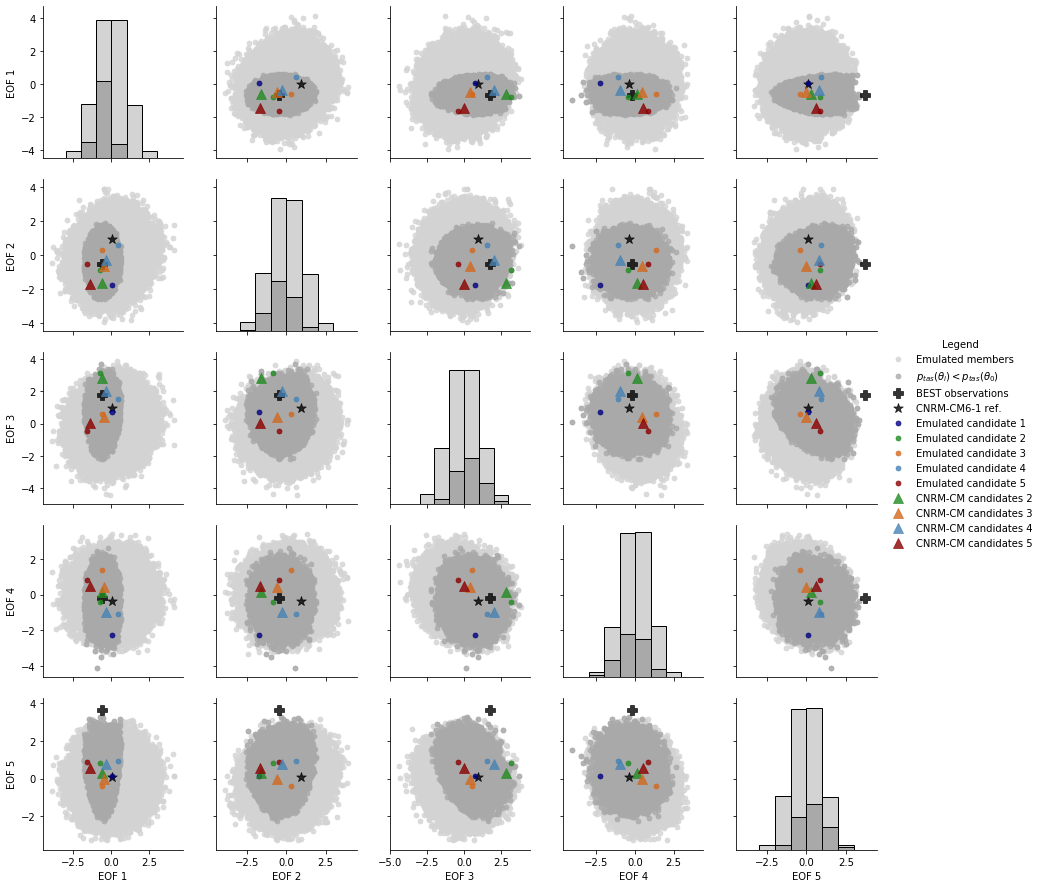

In [101]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray','black', 'black', 
     'navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred', 
     'forestgreen', 'chocolate', 'steelblue', 'darkred' ]
m = ['.','.', 'P','*', 
     '.', '.', '.', '.', '.',
     '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_tas_EOF.png'
plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()

# Spatial maps CNRM-CM candidates

In [44]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff
    

In [45]:
e_diff=[]
p_diff=[]
u_diff=[]
cpt=0
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- 3D full error [obs - mod]
    e_diff_tmp = (obs[variable_obs] - X_sel)
    e_diff.append(e_diff_tmp)
    
     ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_sel[:], nb_dims=2)
    
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff.append(p_diff_tmp)
    
    ## -- 3D u error [e - p]
    u_diff_tmp = (e_diff_tmp - p_diff_tmp)
    u_diff.append(u_diff_tmp)

In [46]:
## -- Compute integrated metrics 
e_sel=[]
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- Compute RMSE 
    e = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel.append(float(e))
df_sel['e'] = e_sel
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6     EOF 7  \
0  None -0.600673 -1.628882  2.834429  0.136754  0.308275 -1.767404 -0.205207   
1  None -0.468910 -0.608184  0.432991  0.421981 -0.038227  1.266231 -0.194175   
2  None -0.330980 -0.299073  2.033083 -0.981662  0.784916  0.020647 -0.343419   
3  None -1.429836 -1.664361  0.011280  0.484553  0.580557 -0.464069 -1.001579   

      EOF 8     EOF 9  ...    EOF 12    EOF 13    EOF 14    EOF 15    EOF 16  \
0  0.171683  0.009046  ...  0.363790 -0.200908 -1.772613  1.074404 -1.329525   
1 -0.338823  0.460896  ... -0.165585  1.316583 -0.326901 -0.181695 -0.962893   
2 -0.518185 -0.218918  ...  0.886200 -1.013706 -2.062732  0.103687 -0.218105   
3 -0.906295 -0.143870  ...  0.197991  0.569985 -0.453556  0.601147 -0.268341   

     EOF 17    EOF 18         p                Legend         e  
0 -1.080801  1.869777  1.271452  CNRM-CM candidates 1  1.312485  
1  0.069598 -0.033189  1.333681  CNRM-CM candidates 2  1.337315  
2 -1.398216  0.509774  1.248067  CNRM-CM candidates 3  1.269987  
3 -1.313195  0.305790  1.432909  CNRM-CM candidates 4  1.447296  

[4 rows x 22 columns]

In [47]:
## -- p1 reference CNRM-CM6-1

## -- 3D full error [obs - mod]
e_diff_p1 = (obs[variable_obs] - p1_amip)

## -- Project 
X_p1 = p1_amip - Mean
X_p1_w = X_p1*W_eof_2D
U_p1 = solver.projectField(X_p1_w, neofs=18, weighted=False, eofscaling=1)

## --Reconstruct 
X_p1_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_p1[:], nb_dims=2)

## -- 3D p error [X_obs_rec - X_mod_rec]
p_diff_p1 = diff_3D_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)

## -- 3D u error [e - p]
u_diff_p1 = (e_diff_p1 - p_diff_p1)

## Figure

In [48]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

## Reference p1

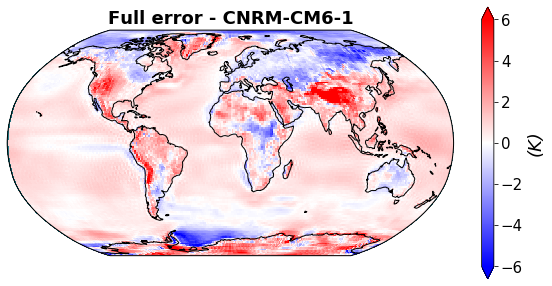

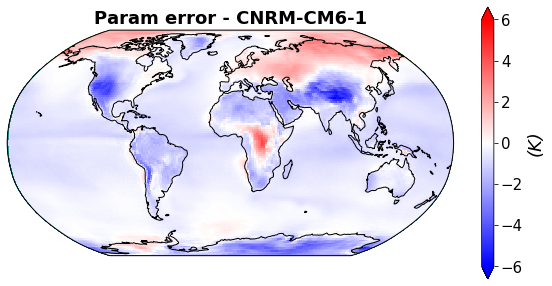

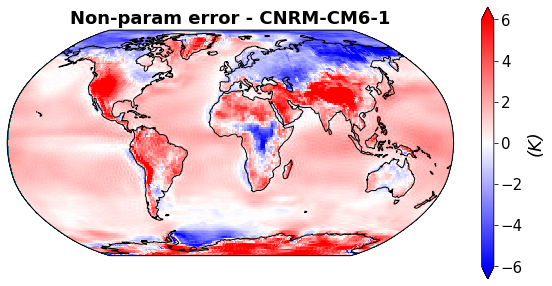

In [49]:
## -- full error e_p1 
dataset = e_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Full error - CNRM-CM6-1'
name_fig = 'Fig4_full_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- param error p_p1 
dataset = p_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Param error - CNRM-CM6-1'
name_fig = 'Fig4_param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- non-param error u_p1 
dataset = u_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Non-param error - CNRM-CM6-1'
name_fig = 'Fig4_non-param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## CNRM-CM candidates 

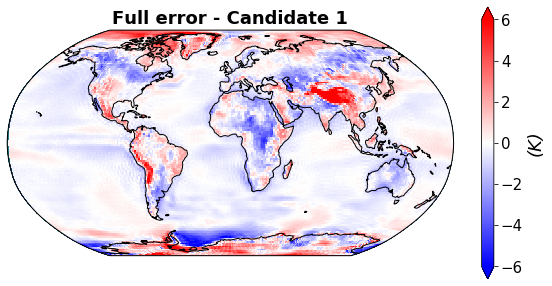

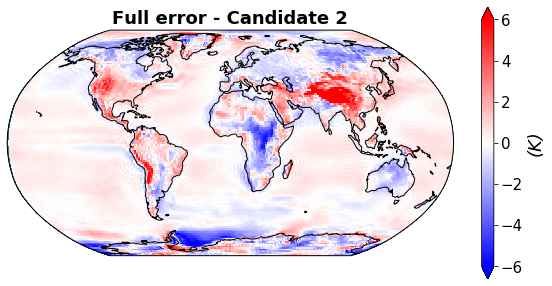

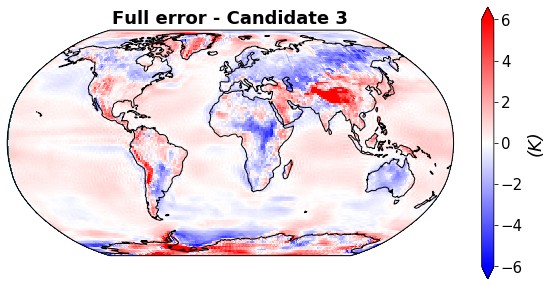

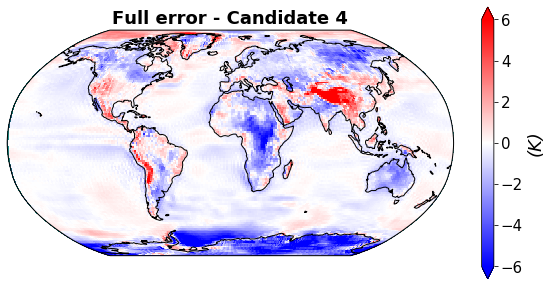

In [50]:
for i in range(0,4,1) :
    dataset = e_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Full error - Candidate '+str(i+1)
    name_fig = 'Fig4_full_error_'+variable+'_candidate'+str(i+1)+'.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

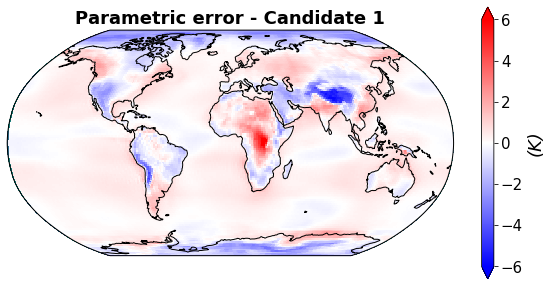

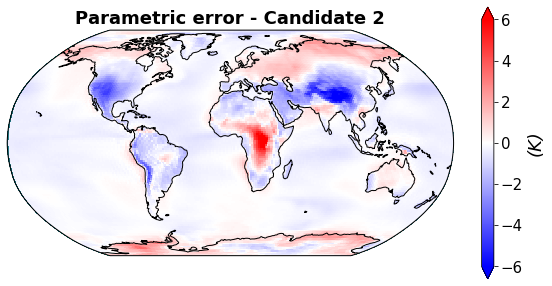

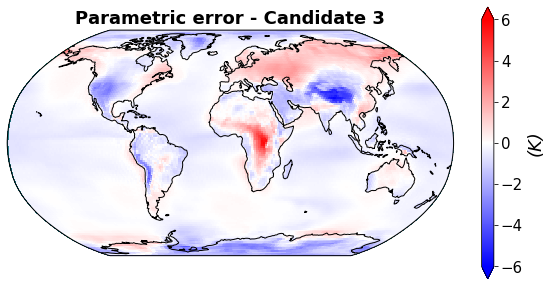

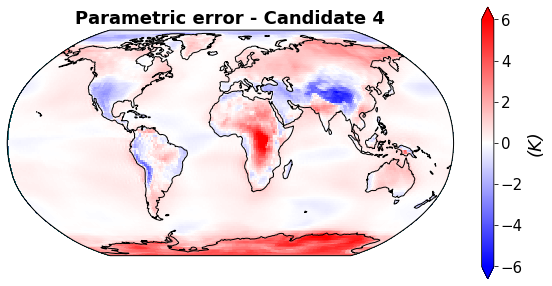

In [51]:
for i in range(0,4,1) :
    dataset = p_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

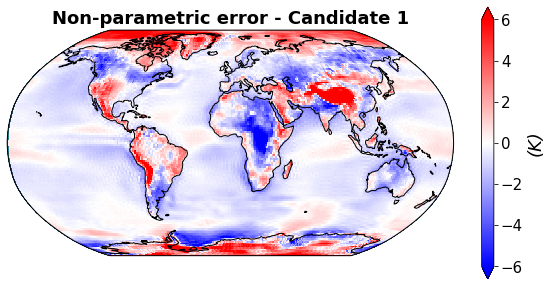

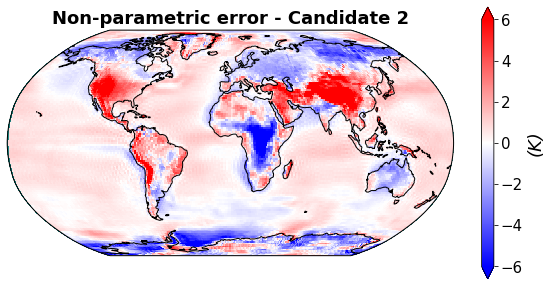

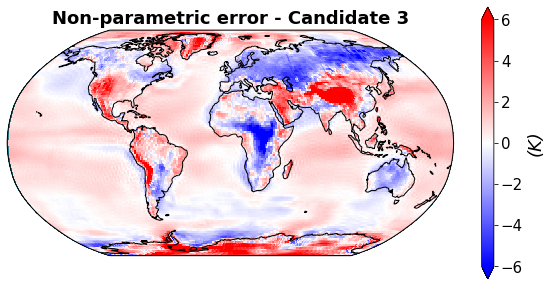

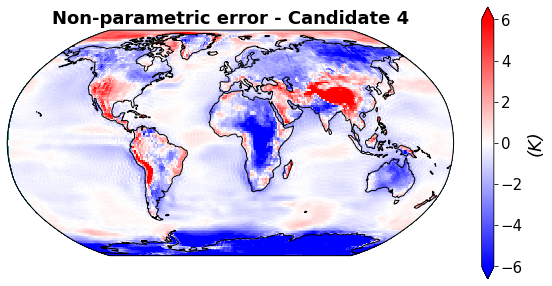

In [52]:
for i in range(0,4,1) :
    dataset = u_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Non-parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_non-param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

# Emulated candidates 

In [53]:
df_cand = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)

## -- Param. error 
p_diff_sel = []
for i in range(1,5,1) :
    U = df_cand.iloc[i][1:19].astype('float')
    
    ## --Reconstruct 
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U, nb_dims=2)
        
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff_sel.append(p_diff)

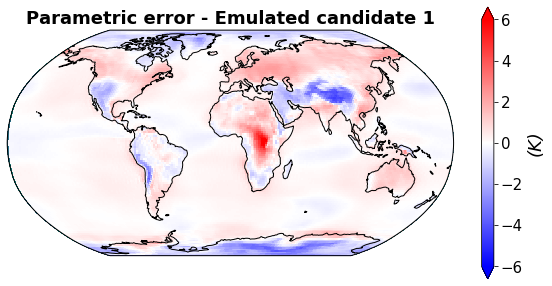

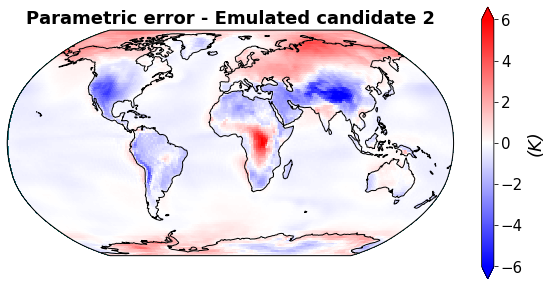

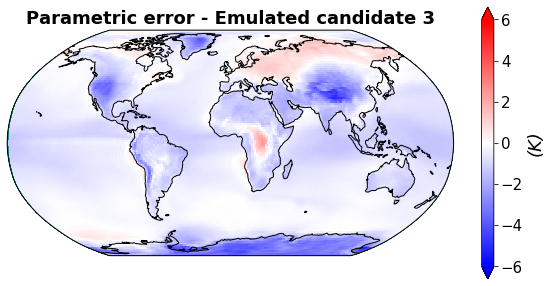

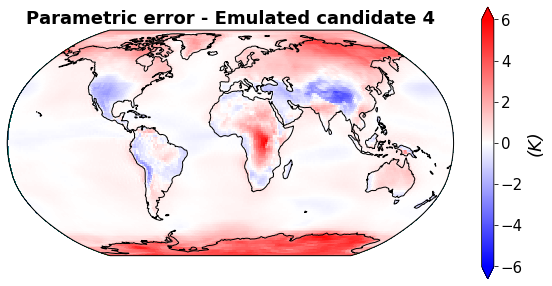

In [54]:
for i in range(0,4,1) :
    dataset = p_diff_sel[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Emulated candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_emul_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [55]:
sqrt(8)

2.8284271247461903

In [56]:
sqrt(4)+sqrt(4)

4.0